# Setup the Environment
We are going to use YOLOv5 model for training.
so lets clone and install the YOLO from github repo

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/face_mask_detection

/content/drive/.shortcut-targets-by-id/1hBfUHWv0JNZn7lzGz8c8g-h2iUUfioSO/face_mask_detection


In [ ]:
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
!pip install -r requirements.txt

fatal: destination path 'yolov5' already exists and is not an empty directory.
/content/drive/.shortcut-targets-by-id/1hBfUHWv0JNZn7lzGz8c8g-h2iUUfioSO/face_mask_detection/yolov5
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 30.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 69.6 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 57.4.0
    Uninstalling setuptools-57.4.0:
      Successfully uninstalled setuptools-57.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cvxpy 1.2.3 requires setuptools<=64.0.2, but you have set

In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
import os
import glob
from datetime import datetime
import xml.etree.ElementTree as ET
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [ ]:
input_data = '/content/drive/MyDrive/face_mask_detection/archive (1)'
output_data = '/content/drive/MyDrive/face_mask_detection/'

# Read and Handle Annotations
Read the data from .xml files
<br>
Extract filename and dimensions of the bouding boxes
<br>
and import that data into a pandas DataFrame

In [ ]:
annotations_path = "/content/drive/MyDrive/face_mask_detection/archive (1)/annotations"
images_path = "/content/drive/MyDrive/face_mask_detection/archive (1)/images"

In [ ]:
dataset = {
            "file":[],
            "name":[],
            "width":[],
            "height":[],
            "xmin":[],
            "ymin":[],
            "xmax":[],
            "ymax":[],
           }

for anno in glob.glob(annotations_path+"/*.xml"):
    tree = ET.parse(anno)

    for elem in tree.iter():
        if 'size' in elem.tag:
            for attr in list(elem):
                if 'width' in attr.tag:
                    width = int(round(float(attr.text)))
                if 'height' in attr.tag:
                    height = int(round(float(attr.text)))

        if 'object' in elem.tag:
            for attr in list(elem):

                if 'name' in attr.tag:
                    name = attr.text
                    dataset['name']+=[name]
                    dataset['width']+=[width]
                    dataset['height']+=[height]
                    dataset['file']+=[anno.split('/')[-1][0:-4]]

                if 'bndbox' in attr.tag:
                    for dim in list(attr):
                        if 'xmin' in dim.tag:
                            xmin = int(round(float(dim.text)))
                            dataset['xmin']+=[xmin]
                        if 'ymin' in dim.tag:
                            ymin = int(round(float(dim.text)))
                            dataset['ymin']+=[ymin]
                        if 'xmax' in dim.tag:
                            xmax = int(round(float(dim.text)))
                            dataset['xmax']+=[xmax]
                        if 'ymax' in dim.tag:
                            ymax = int(round(float(dim.text)))
                            dataset['ymax']+=[ymax]

In [ ]:
df=pd.DataFrame(dataset)
df.head()

file          name  width  height  xmin  ymin  xmax  ymax
0  maksssksksss110  without_mask    400     267     6   111    43   148
1  maksssksksss110  without_mask    400     267    22    20    49    46
2  maksssksksss110     with_mask    400     267    48    12    70    37
3  maksssksksss110     with_mask    400     267   113     1   136    24
4  maksssksksss110  without_mask    400     267    78    17   106    46

In [ ]:
name_dict = {
    'with_mask': 0,
    'mask_weared_incorrect': 1,
    'without_mask': 2
}

df['class'] = df['name'].map(name_dict)

In [ ]:
np.sort(df.name.unique())

array(['mask_weared_incorrect', 'with_mask', 'without_mask'], dtype=object)

In [ ]:
labels = df.name.unique()
labels_list = [df['name'].value_counts()["with_mask"], df['name'].value_counts()["mask_weared_incorrect"], df['name'].value_counts()["without_mask"]]
print(labels_list)
print(labels)

[3232, 123, 717]
['without_mask' 'with_mask' 'mask_weared_incorrect']


# Graph the train data statistics

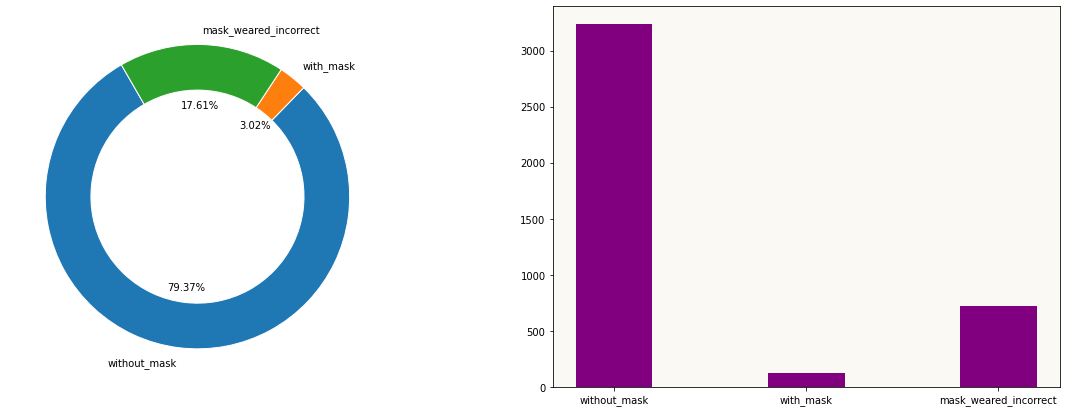

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize =(20,7))
background_color = '#faf9f4'
ax1.set_facecolor(background_color)
ax2.set_facecolor(background_color)
ax1.pie(labels_list, wedgeprops=dict(width=0.3, edgecolor='w'),
        labels=labels, radius=1, startangle=120, autopct='%1.2f%%')

ax2 = plt.bar(labels, list(labels_list),
              color ='purple',width = 0.4)

plt.show()

# Train Test Split
Split the dataset into training testing and validation set
<br>
separate the data in different folder inside the Yolo directory
<br>
and Normalize data

In [ ]:
fileNames = [*os.listdir("/content/drive/MyDrive/face_mask_detection/archive (1)/images")]
print('There are {} images in the dataset'.format(len(fileNames)))

There are 853 images in the dataset


In [ ]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(fileNames, test_size=0.1, random_state=22)
test, val = train_test_split(test, test_size=0.7, random_state=22)
print("Length of Train =",len(train))
print("="*30)
print("Length of Valid =",len(val))
print("="*30)
print("Length of test =", len(test))

Length of Train = 767
Length of Valid = 61
Length of test = 25


In [ ]:
# create separate train test and validation dir inside yolo/data/
os.chdir('/content/drive/MyDrive/face_mask_detection/')
os.mkdir('./yolov5/data/train')
os.mkdir('./yolov5/data/val')
os.mkdir('./yolov5/data/test')
os.mkdir('./yolov5/data/train/images')
os.mkdir('./yolov5/data/train/labels')
os.mkdir('./yolov5/data/test/images')
os.mkdir('./yolov5/data/test/labels')
os.mkdir('./yolov5/data/val/images')
os.mkdir('./yolov5/data/val/labels')

In [ ]:

from PIL import Image

def copyImages(imageList, folder_Name):
    for image in imageList:
        img = Image.open(input_data+"/images/"+image)
        img1 = img.resize((640, 480))
        _ = img1.save(output_data+"/yolov5/data/"+folder_Name+"/images/"+image)

copyImages(train, "train")
copyImages(val, "val")
copyImages(test, "test")

In [ ]:
df.head()

file          name  width  height  xmin  ymin  xmax  ymax  class
0  maksssksksss110  without_mask    400     267     6   111    43   148      2
1  maksssksksss110  without_mask    400     267    22    20    49    46      2
2  maksssksksss110     with_mask    400     267    48    12    70    37      0
3  maksssksksss110     with_mask    400     267   113     1   136    24      0
4  maksssksksss110  without_mask    400     267    78    17   106    46      2

In [ ]:
df['xmax'] = (640/df['width'])*df['xmax']
df['ymax'] = (480/df['height'])*df['ymax']
df['xmin'] = (640/df['width'])*df['xmin']
df['ymin'] = (480/df['height'])*df['ymin']

In [ ]:
df[['xmax', 'ymax', 'xmin', 'ymin']] = df[['xmax', 'ymax', 'xmin', 'ymin']].astype('int64')

In [ ]:
df['x_center'] = (df['xmax']+df['xmin'])/(2*640)
df['y_center'] = (df['ymax']+df['ymin'])/(2*480)
df['box_height'] = (df['xmax']-df['xmin'])/(640)
df['box_width'] = (df['ymax']-df['ymin'])/(480)

In [ ]:
df.head()

file          name  width  height  xmin  ymin  xmax  ymax  \
0  maksssksksss110  without_mask    400     267     9   199    68   266   
1  maksssksksss110  without_mask    400     267    35    35    78    82   
2  maksssksksss110     with_mask    400     267    76    21   112    66   
3  maksssksksss110     with_mask    400     267   180     1   217    43   
4  maksssksksss110  without_mask    400     267   124    30   169    82   

   class  x_center  y_center  box_height  box_width  
0      2  0.060156  0.484375    0.092188   0.139583  
1      2  0.088281  0.121875    0.067187   0.097917  
2      0  0.146875  0.090625    0.056250   0.093750  
3      0  0.310156  0.045833    0.057813   0.087500  
4      2  0.228906  0.116667    0.070312   0.108333

In [ ]:
df = df.astype('string')

In [ ]:
def create_labels(image_list, data_name):
    fileNames = [x.split(".")[0] for x in image_list]

    for name in fileNames:
        data = df[df.file==name]
        box_list = []

        for index in range(len(data)):
            row = data.iloc[index]
            box_list.append(row['class']+" "+row["x_center"]+" "+row["y_center"]\
                        +" "+row["box_height"]+" "+row["box_width"])

        text = "\n".join(box_list)
        with open(output_data+"/yolov5/data/"+data_name+"/labels/"+name+".txt", "w") as file:
            file.write(text)


create_labels(train, "train")
create_labels(val, "val")
create_labels(test, "test")

# Configure the Model

In [ ]:
# go to YOLO directory
%cd /content/drive/MyDrive/face_mask_detection/yolov5

/content/drive/.shortcut-targets-by-id/1hBfUHWv0JNZn7lzGz8c8g-h2iUUfioSO/face_mask_detection/yolov5


In [ ]:
# to display images
from IPython.display import Image, clear_output
import torch
from yolov5 import utils
display = utils.notebook_init()

In [ ]:
# configure .yaml file to guide the model for training
yaml_text = """train: data/train/images
val: data/train/images

nc: 3
names: ['with_mask', 'mask_weared_incorrect', 'without_mask']"""

with open("data/data.yaml", 'w') as file:
    file.write(yaml_text)

%cat data/data.yaml

train: data/train/images
val: data/train/images

nc: 3
names: ['with_mask', 'mask_weared_incorrect', 'without_mask']

In [ ]:
#customize iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [ ]:
%%writetemplate models/custom_yolov5s.yaml

# parameters
nc: 3  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
    - [10,13, 16,30, 33,23]  # P3/8
    - [30,61, 62,45, 59,119]  # P4/16
    - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, BottleneckCSP, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
    [[-1, 1, Conv, [512, 1, 1]],
    [-1, 1, nn.Upsample, [None, 2, 'nearest']],
    [[-1, 6], 1, Concat, [1]],  # cat backbone P4
    [-1, 3, BottleneckCSP, [512, False]],  # 13

    [-1, 1, Conv, [256, 1, 1]],
    [-1, 1, nn.Upsample, [None, 2, 'nearest']],
    [[-1, 4], 1, Concat, [1]],  # cat backbone P3
    [-1, 3, BottleneckCSP, [256, False]],  # 17 (P3/8-small)

    [-1, 1, Conv, [256, 3, 2]],
    [[-1, 14], 1, Concat, [1]],  # cat head P4
    [-1, 3, BottleneckCSP, [512, False]],  # 20 (P4/16-medium)

    [-1, 1, Conv, [512, 3, 2]],
    [[-1, 10], 1, Concat, [1]],  # cat head P5
    [-1, 3, BottleneckCSP, [1024, False]],  # 23 (P5/32-large)

    [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
    ]

# Train yolov5s on our custom data

In [ ]:
# also using pre-trained weights from yolov5.pt model

start = datetime.now()
!python train.py --img 640 --batch 32 --epochs 50 --data data/data.yaml --cfg models/custom_yolov5s.yaml --weights yolov5s.pt --name yolov5s_results  --cache
end = datetime.now()

train: weights=yolov5s.pt, cfg=models/custom_yolov5s.yaml, data=data/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=50, batch_size=32, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=yolov5s_results, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-102-ge4d8360 Python-3.8.10 torch-1.13.1+cu116 CUDA:0 (NVIDIA A100-SXM4-40GB, 40536MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4

In [ ]:
print("Runtime =",end-start)

Runtime = 0:08:04.897305


# Visualize the training results

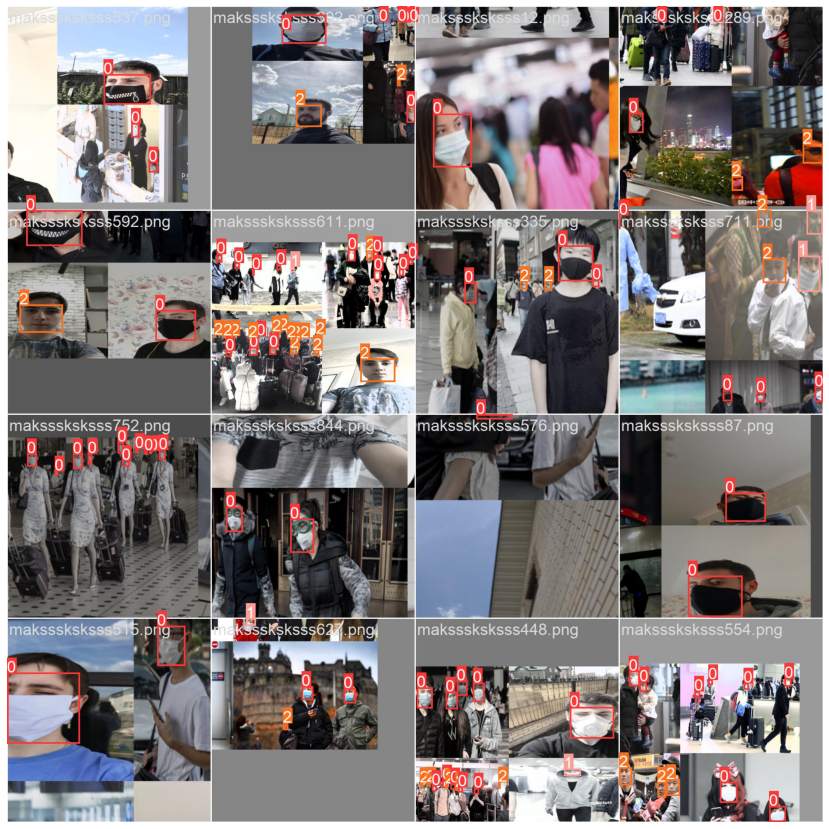

In [ ]:
img = plt.imread('runs/train/yolov5s_results4/train_batch2.jpg')
plt.figure(figsize=(30,15))
plt.imshow(img)
plt.axis('off')
plt.show()

In [ ]:
os.listdir("/content/drive/MyDrive/face_mask_detection/yolov5/runs/train/yolov5s_results4")

['weights',
 'hyp.yaml',
 'opt.yaml',
 'events.out.tfevents.1676531889.201c440cdc19.13703.0',
 'labels_correlogram.jpg',
 'labels.jpg',
 'train_batch0.jpg',
 'train_batch1.jpg',
 'train_batch2.jpg',
 'results.csv',
 'val_batch0_labels.jpg',
 'val_batch0_pred.jpg',
 'val_batch1_labels.jpg',
 'val_batch1_pred.jpg',
 'val_batch2_labels.jpg',
 'val_batch2_pred.jpg',
 'P_curve.png',
 'R_curve.png',
 'PR_curve.png',
 'F1_curve.png',
 'confusion_matrix.png',
 'results.png']

In [ ]:
results_df = pd.read_csv("/content/drive/MyDrive/face_mask_detection/yolov5/runs/train/yolov5s_results4/results.csv")

In [ ]:
results_df.head()

epoch        train/box_loss        train/obj_loss  \
0                     0              0.106500              0.061836   
1                     1              0.095016              0.072640   
2                     2              0.088445              0.072905   
3                     3              0.081000              0.063558   
4                     4              0.074374              0.056873   

         train/cls_loss     metrics/precision  ...          val/obj_loss  \
0              0.035543              0.000762  ...              0.054762   
1              0.029454              0.000655  ...              0.056602   
2              0.023175              0.000568  ...              0.055799   
3              0.020282              0.785960  ...              0.050680   
4              0.018740              0.788120  ...              0.040553   

           val/cls_loss                 x/lr0                 x/lr1  \
0              0.033199              0.079300              0.002300   
1              0.029524              0.057607              0.004607   
2              0.029417              0.035819              0.006819   
3              0.024580              0.013936              0.008936   
4              0.018164              0.009208              0.009208   

                  x/lr2  
0              0.002300  
1              0.004607  
2              0.006819  
3              0.008936  
4              0.009208  

[5 rows x 14 columns]

In [ ]:
results_df.columns

Index(['               epoch', '      train/box_loss', '      train/obj_loss',
       '      train/cls_loss', '   metrics/precision', '      metrics/recall',
       '     metrics/mAP_0.5', 'metrics/mAP_0.5:0.95', '        val/box_loss',
       '        val/obj_loss', '        val/cls_loss', '               x/lr0',
       '               x/lr1', '               x/lr2'],
      dtype='object')

In [ ]:
columns_list = []

for name in results_df.columns:
    if name == '               epoch':
        continue
    else:
        columns_list.append(results_df[name].tolist())

In [ ]:
def plot_graphs_yolov5(values, titles, color):
    plt.figure(figsize = (30, 10))

    for i, title in enumerate(titles):
        plt.subplot(1, len(titles), i + 1)
        plt.plot(values[i], linewidth=5, color=color)
        plt.title(title, size=30)

    plt.show()

# **Plot the losses for the training data**

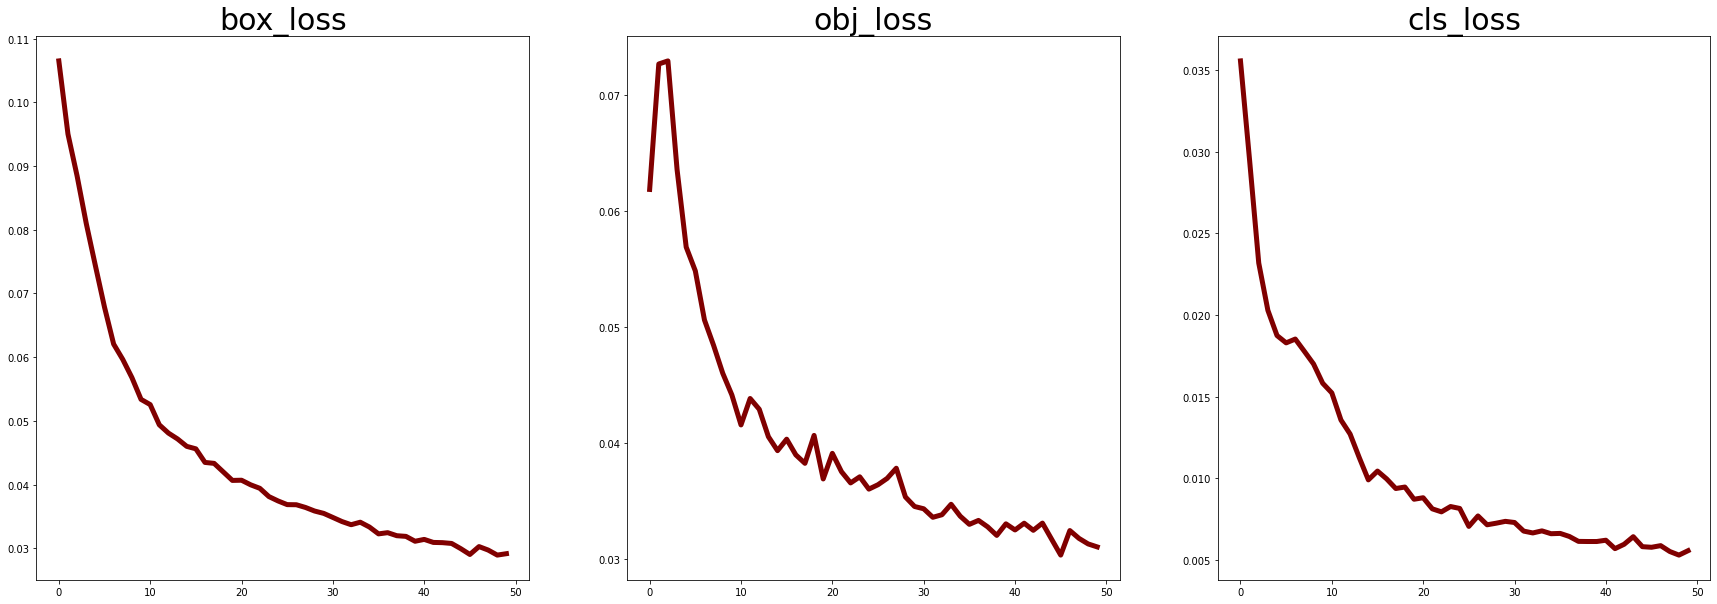

In [ ]:
losses = columns_list[:3]

titles = ['box_loss', 'obj_loss', 'cls_loss']

plot_graphs_yolov5(losses, titles, 'maroon')

# **Plot the metrics for the *training* data**

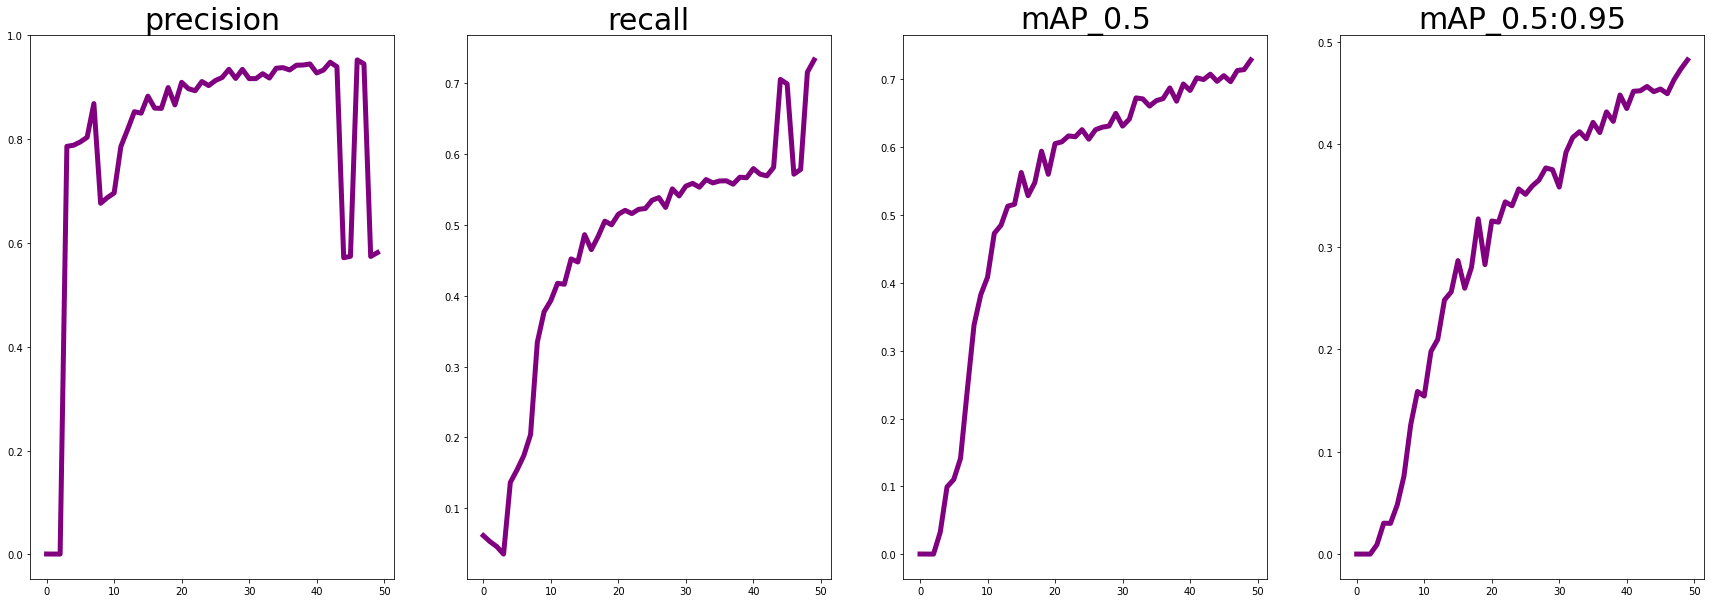

In [ ]:
metrics = columns_list[3:7]

titles = ['precision', 'recall', 'mAP_0.5', 'mAP_0.5:0.95']

plot_graphs_yolov5(metrics, titles, 'purple')

# **Plot the losses for the *validation* data**

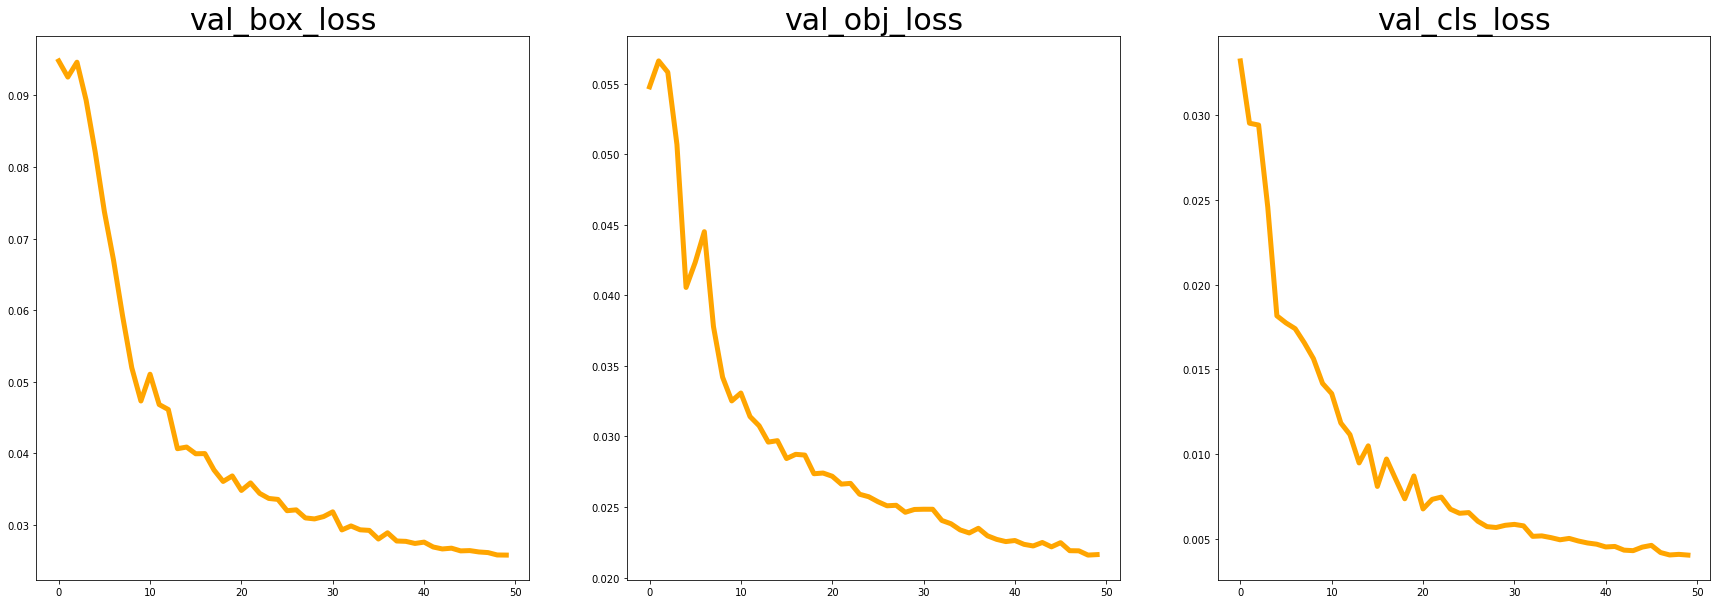

In [ ]:
validation = columns_list[7:10]

titles = ['val_box_loss', 'val_obj_loss', 'val_cls_loss']

plot_graphs_yolov5(validation, titles, 'orange')

# Plot the learning rates

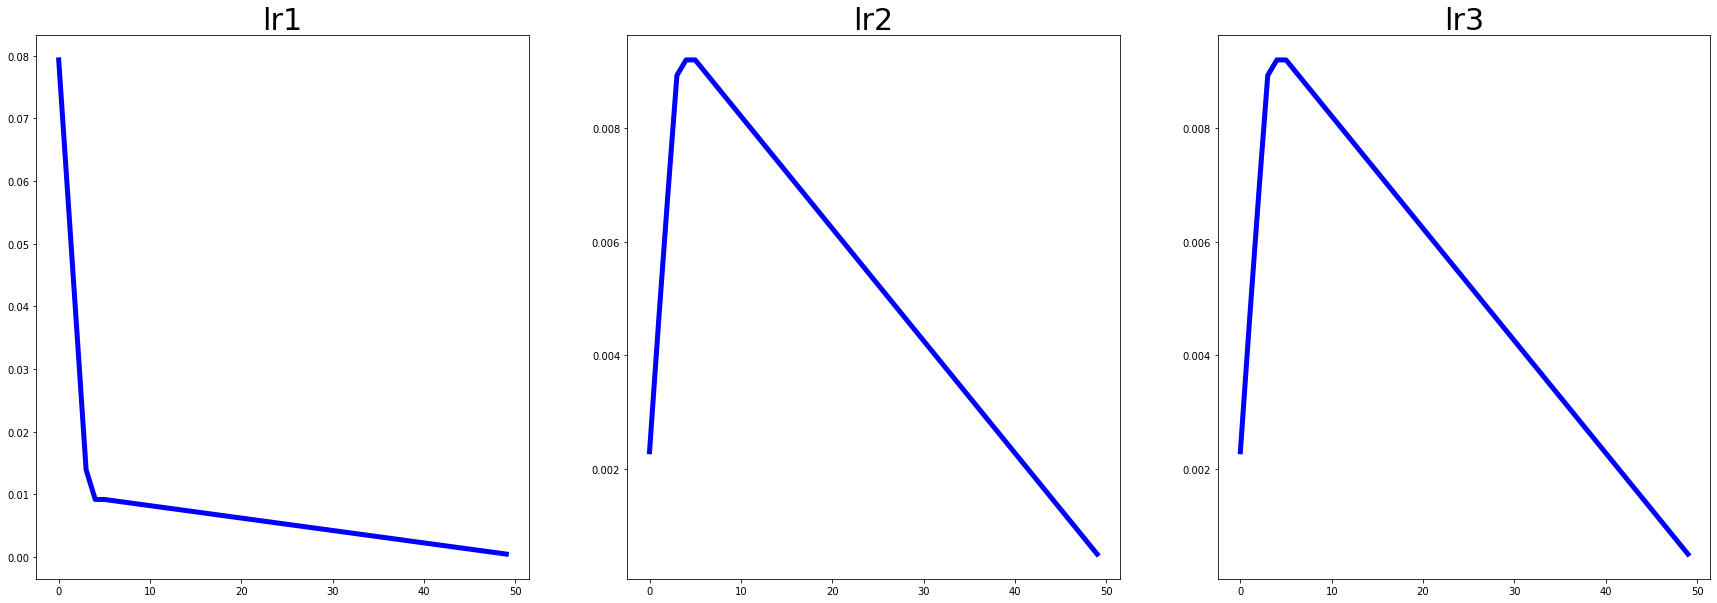

In [ ]:
learning_rates = columns_list[10:13]

titles = ['lr1', 'lr2', 'lr3']

plot_graphs_yolov5(learning_rates, titles, 'blue')

# Show the confusion matrix

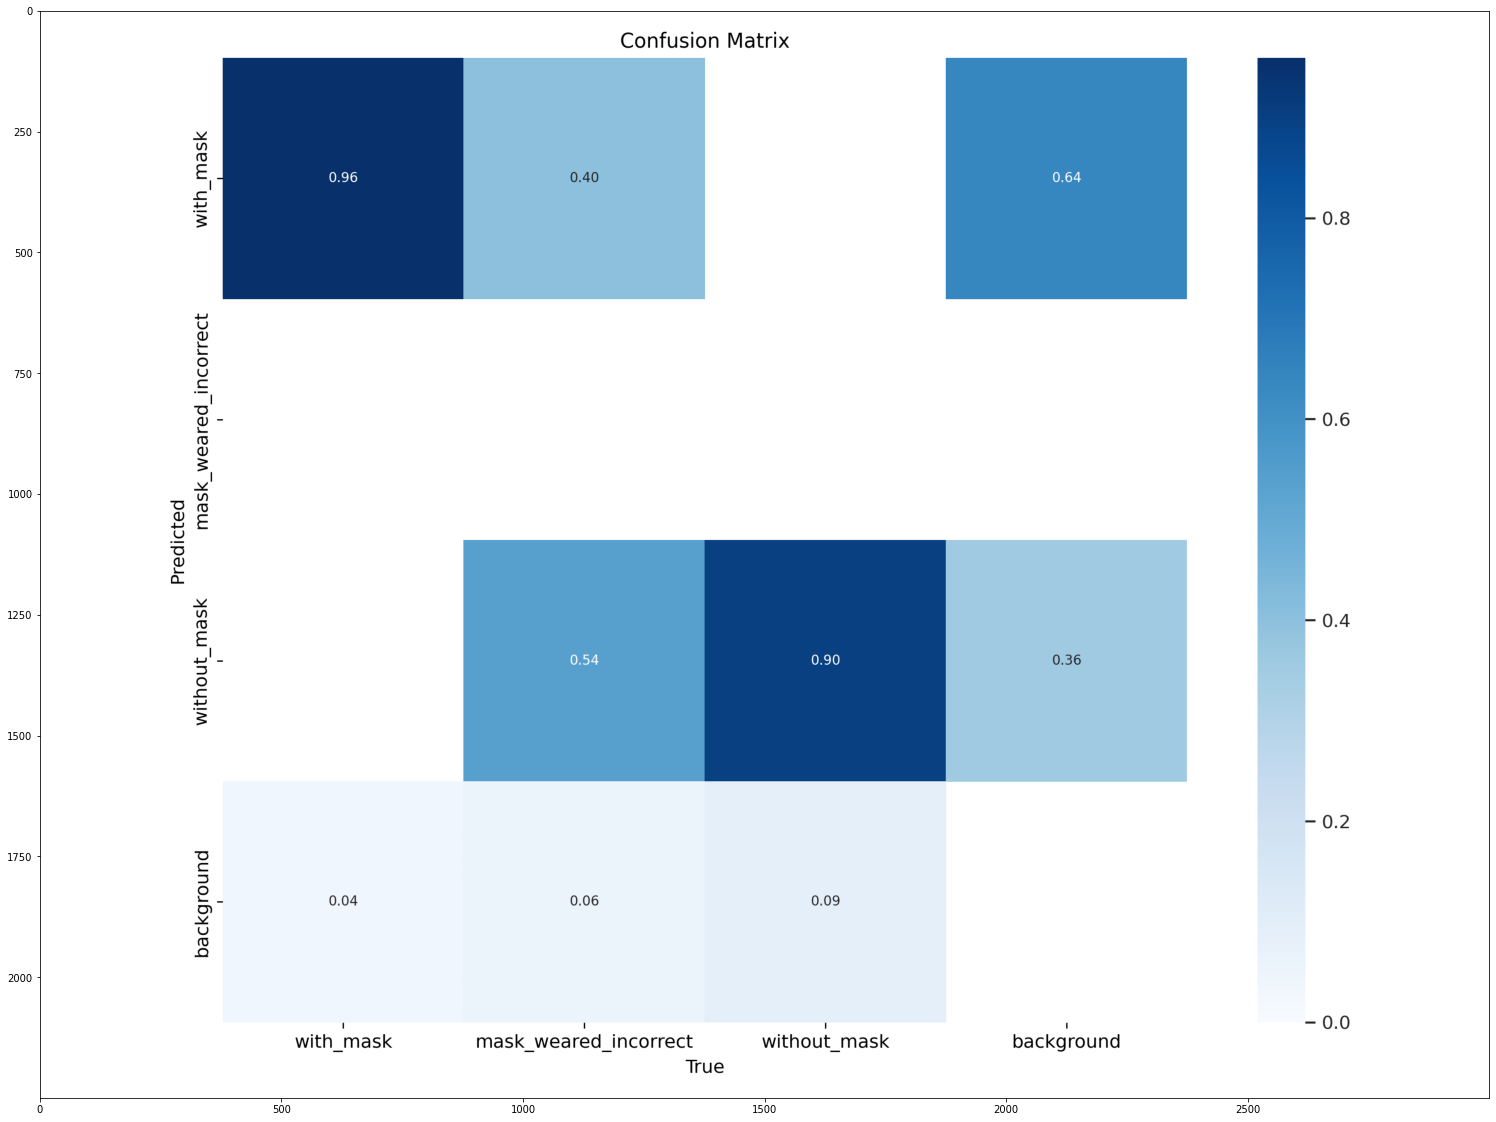

In [ ]:
img = plt.imread('/content/drive/MyDrive/face_mask_detection/yolov5/runs/train/yolov5s_results4/confusion_matrix.png')
plt.figure(figsize=(30,20))
plt.imshow(img)

# Test the Model
lets test the model over test images we had separated before training

In [ ]:
!python detect.py --source data/test/images/ --weight runs/train/yolov5s_results4/weights/best.pt --name expTestImage --conf 0.4

detect: weights=['runs/train/yolov5s_results4/weights/best.pt'], source=data/test/images/, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=expTestImage, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-102-ge4d8360 Python-3.8.10 torch-1.13.1+cu116 CUDA:0 (NVIDIA A100-SXM4-40GB, 40536MiB)

Fusing layers... 
custom_YOLOv5s summary: 182 layers, 7251912 parameters, 0 gradients
image 1/25 /content/drive/MyDrive/face_mask_detection/yolov5/data/test/images/maksssksksss0.png: 480x640 1 with_mask, 2 without_masks, 17.7ms
image 2/25 /content/drive/MyDrive/face_mask_detection/yolov5/data/test/images/maksssksksss120.png: 480x640 1 with_mask, 11.6ms
image 3/25 /content/drive/MyDrive/face_mask_detec

results are saved inside run/detect/expTestImage dir <br>
let's check the results to see how our model performed

In [ ]:
color_dict = {
    'with_mask': (0, 255, 0),
    'mask_weared_incorrect':  (0, 0, 255),
    'without_mask': (255, 0, 0)
}

In [ ]:
def show_image(img_id):
    df_image = df[df.file==img_id]
    df_image[['xmin', 'ymin', 'xmax', 'ymax']] = df_image[['xmin', 'ymin', 'xmax', 'ymax']].astype('int64')
    path = 'data/test/images/'+img_id# +'.png'
    img = plt.imread(path)

    imge = img.copy()

    for index in range(len(df_image)):
        row = df_image.iloc[index]
        cv2.rectangle(imge,
                      (row['xmin'], row['ymin']),
                      (row['xmax'], row['ymax']),
                      color=color_dict[row['name']],
                      thickness=2)

    img_pred = plt.imread('runs/detect/expTestImage2/'+img_id)
    # ===================================
    plt.figure(figsize=(30,20))

    plt.subplot(1,2,1)
    plt.imshow(imge)
    plt.axis('off')
    plt.title('Test image')

    plt.subplot(1,2,2)
    plt.imshow(img_pred)
    plt.axis('off')
    plt.title('Image with Predicted Box')

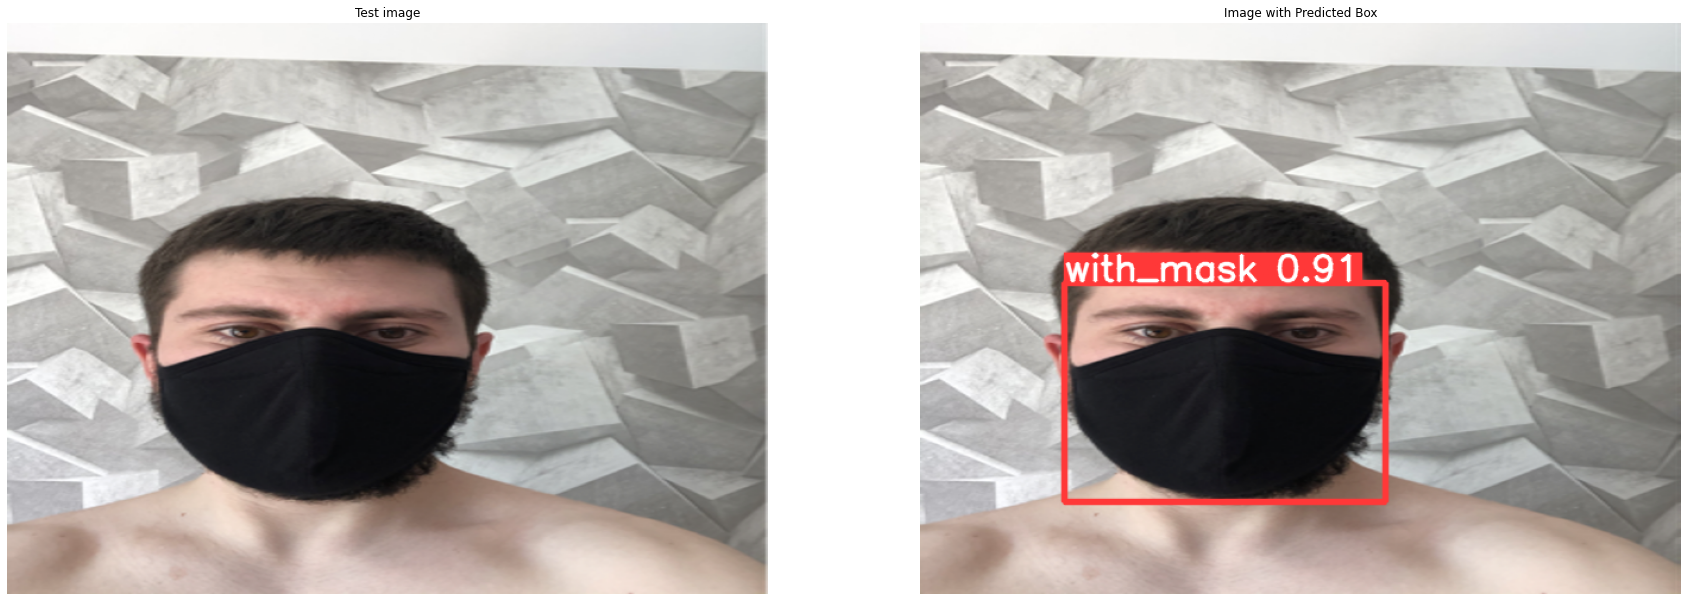

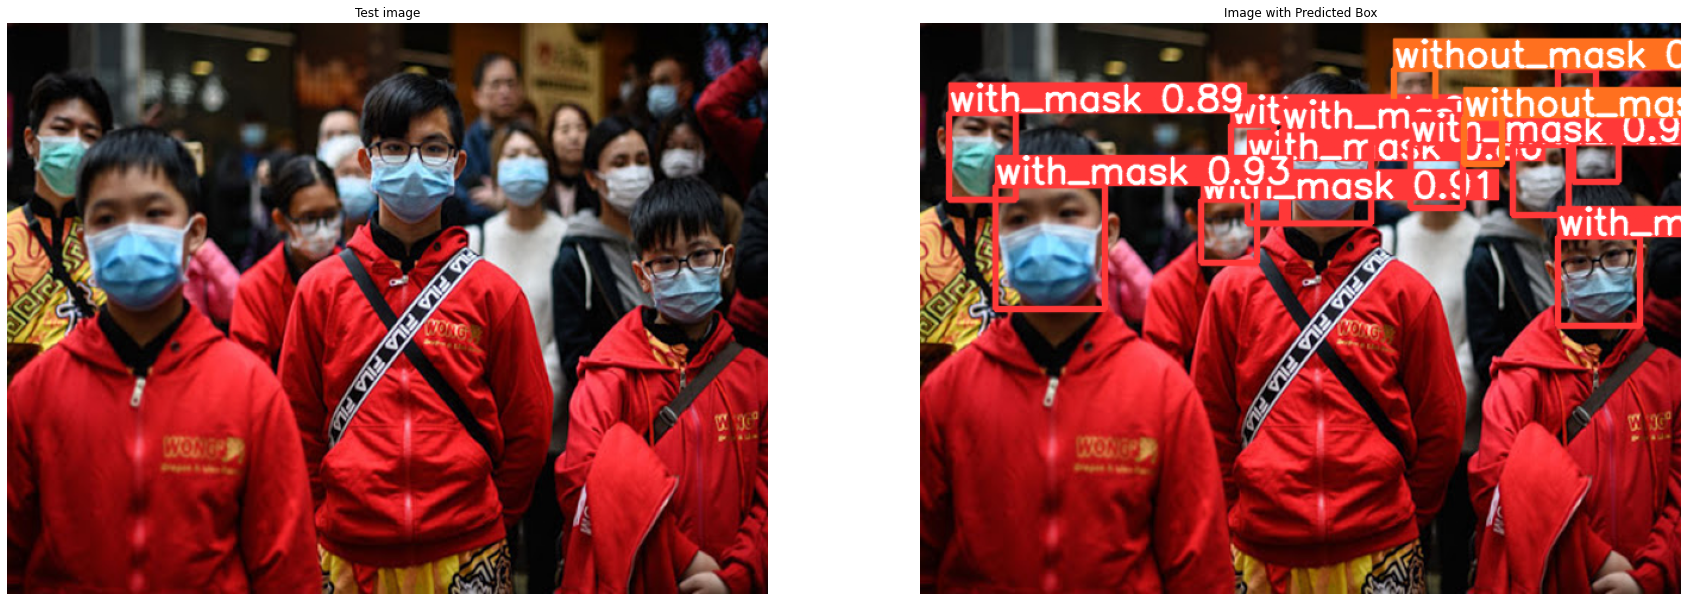

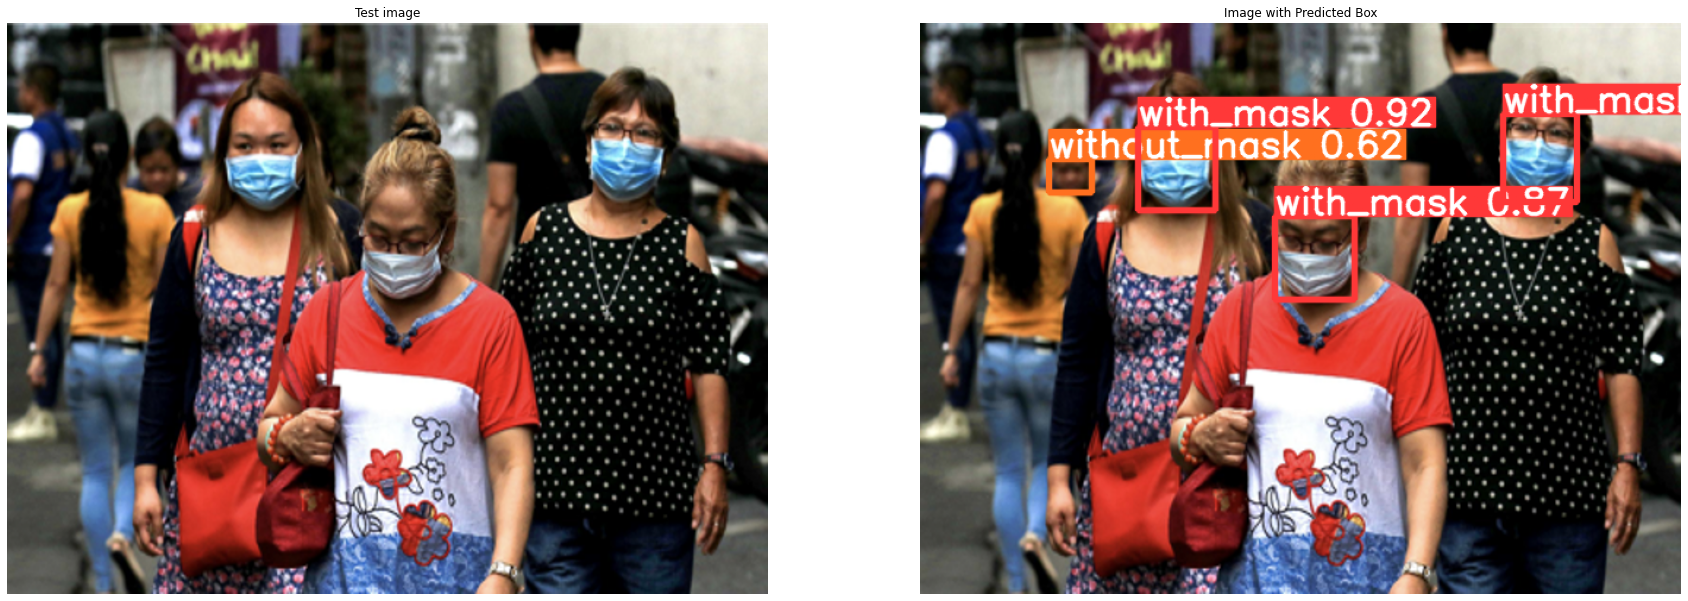

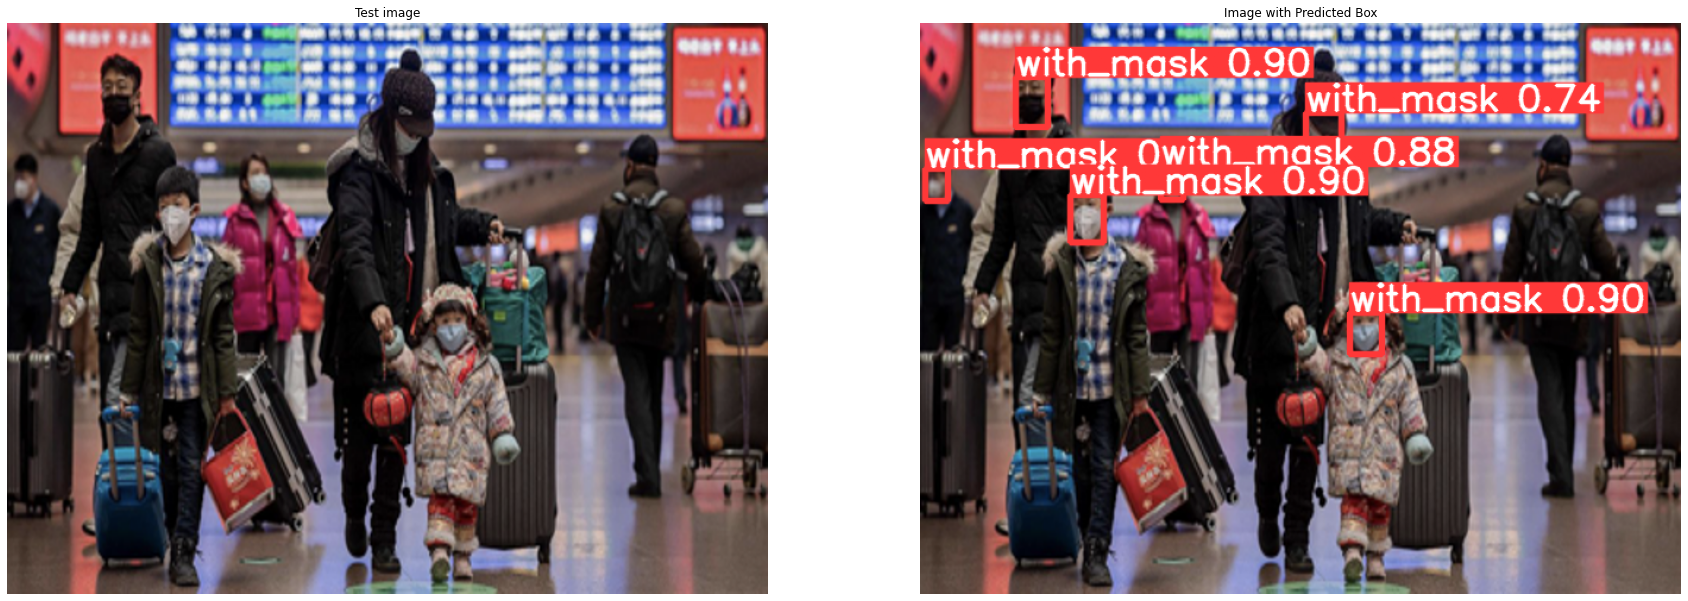

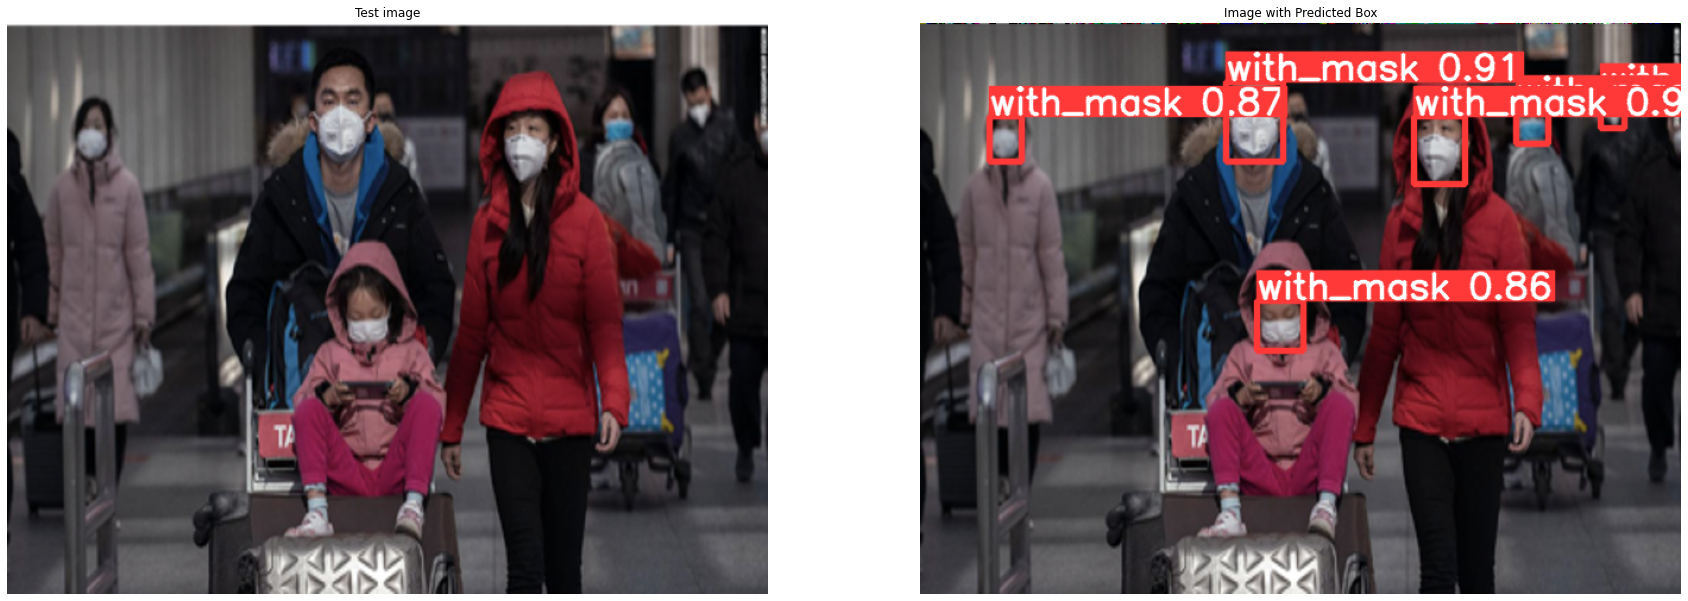

In [ ]:
import os, random
for i in range(5):
    show_image(random.choice(os.listdir("data/test/images/")))
    plt.show()

**Live Detection**

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
def take_photo(filename='/content/photo_1.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);
      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});
      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();
      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);
      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);
      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to /content/photo_1.jpg


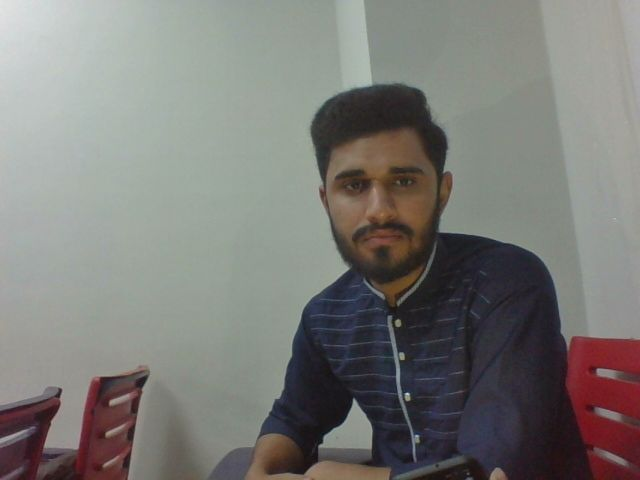

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [ ]:
!python detect.py --source /content/photo_1.jpg --weight runs/train/yolov5s_results4/weights/best.pt --name expTestImage --conf 0.4

detect: weights=['runs/train/yolov5s_results4/weights/best.pt'], source=/content/photo_1.jpg, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=expTestImage, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-102-ge4d8360 Python-3.8.10 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
custom_YOLOv5s summary: 182 layers, 7251912 parameters, 0 gradients
image 1/1 /content/photo_1.jpg: 480x640 1 without_mask, 13.6ms
Speed: 0.6ms pre-process, 13.6ms inference, 36.1ms NMS per image at shape (1, 3, 640, 640)
Results saved to runs/detect/expTestImage26


In [ ]:
from google.colab.patches import cv2_imshow

In [ ]:
img = cv2.imread("/content/drive/MyDrive/face_mask_detection/yolov5/runs/detect/expTestImage26/photo_1.jpg")
cv2_imshow(img)

# END